In [1]:
!pip install pyod
!pip install rrcf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.4/153.4 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-1.1.0-py3-none-any.whl size=185329 sha256=d9a99557bf5f7822fb5021d1dbb3c63b76f2d8a3b40a2a89a6100261933d9c62
  Stored in directory: /root/.cache/pip/wheels/36/8e/e2/e932956b10b843eb6be9eefa70b5c1bee7b561be14c423b136
Successfully built pyod
  Preparing metadata (setup.py) ... done
  Created wheel for rrcf: filename=rrcf-0.4.4-py3-none-any.whl size=10601 sha256=fce0aea34f9a9446679ccfb802b3c77ebf27eea3b416d0330c298ede2d3d7679
  Stored in directory: /root/.cache/pip/wheels/51/d4/43/6ac8270752946ee2223022ce0ed0d66c9455d000e1facb53a6
Successfully built rrcf


In [2]:
import rrcf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from pyod.utils.data import generate_data, get_outliers_inliers

In [3]:
# Data Loading
X, Y = generate_data(behaviour='new', n_features=10,
                     train_only=True,
                     contamination=0.1,
                     random_state=2023)

In [4]:
# Naming for columns
col_list = []
for i in range(X.shape[1]):
    a = 'X{}'.format(i+1)
    col_list.append(a)

In [5]:
# Make DF
df = pd.DataFrame(X, columns = col_list)
df['Y'] = Y

Text(0.5, 1.0, 'Ground Truth')

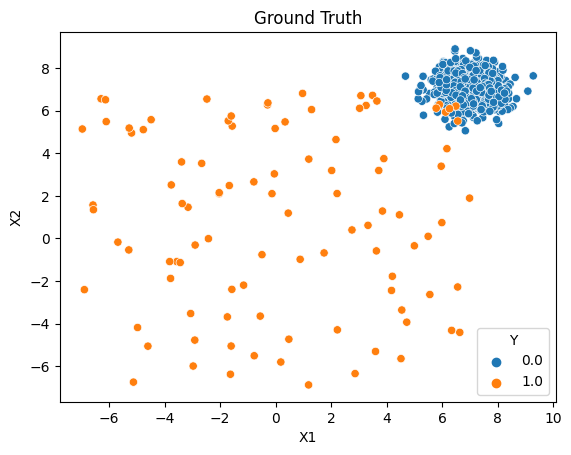

In [6]:
# Data 분포 확인하기 X1, X2
sns.scatterplot(x='X1', y='X2', hue='Y', data=df);
plt.title('Ground Truth')

## [Robust Random Cut Forest Parameter]
  - Introduction page : https://klabum.github.io/rrcf/
  - Code gitgub : https://github.com/kLabUM/rrcf
  - rrcf는 특이하게 parameter를 Code로 짜줘야함

In [7]:
df_array = np.array(df)

# Set parameters
num_trees = 150
tree_size = 500

# Construct forest
forest = []
while len(forest) < num_trees:
    # Select random subsets of points uniformly from point set
    ixs = np.random.choice(df_array.shape[0], size=(df_array.shape[0] // tree_size, tree_size),
                           replace=False)
    # Add sampled trees to forest
    trees = [rrcf.RCTree(df_array[ix, :2], index_labels=ix) for ix in ixs]
    forest.extend(trees)

# Compute average CoDisp
avg_codisp = pd.Series(0.0, index=np.arange(df_array.shape[0]))
index = np.zeros(df_array.shape[0])
for tree in forest:
    codisp = pd.Series({leaf : tree.codisp(leaf) for leaf in tree.leaves})
    avg_codisp[codisp.index] += codisp
    np.add.at(index, codisp.index.values, 1)
avg_codisp /= index

In [8]:
avg_codisp

0       6.971351
1       4.239403
2      11.504743
3       4.225689
4       4.194777
         ...    
995    21.843401
996    22.831446
997    37.417650
998    26.697996
999    20.620284
Length: 1000, dtype: float64

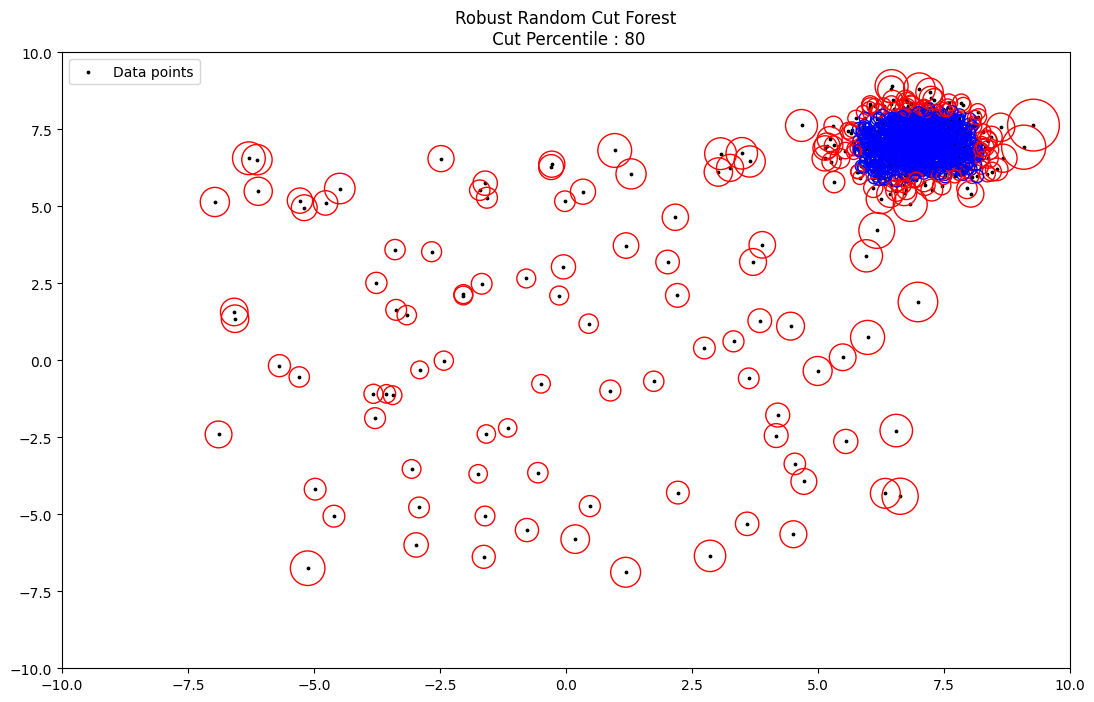

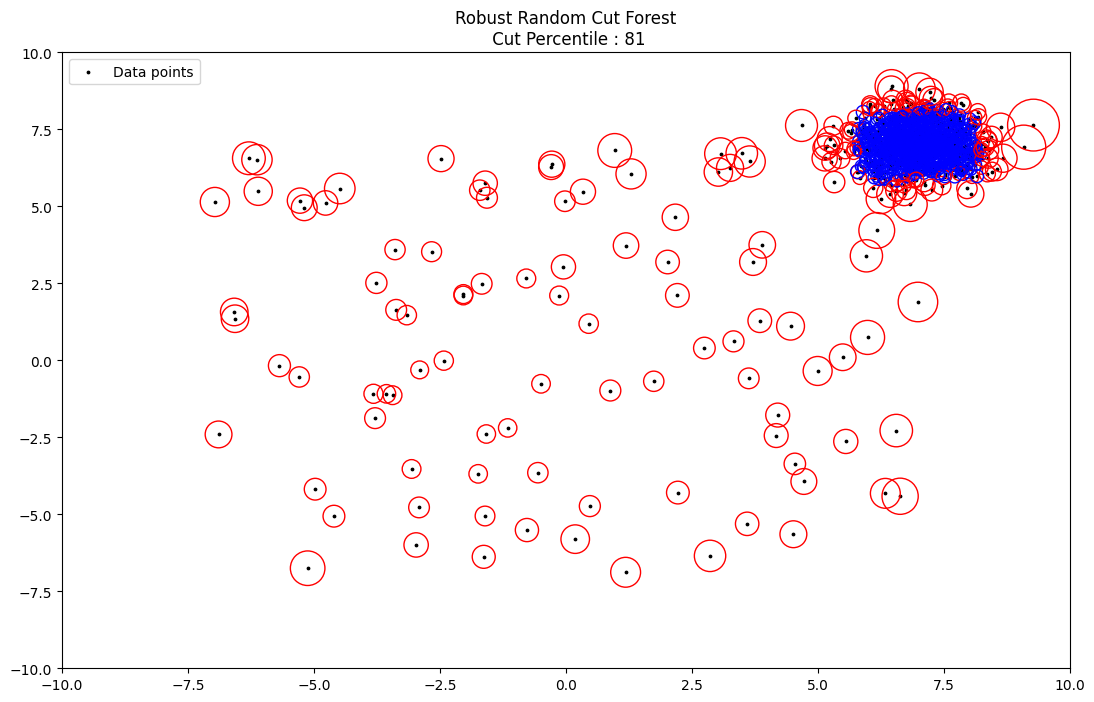

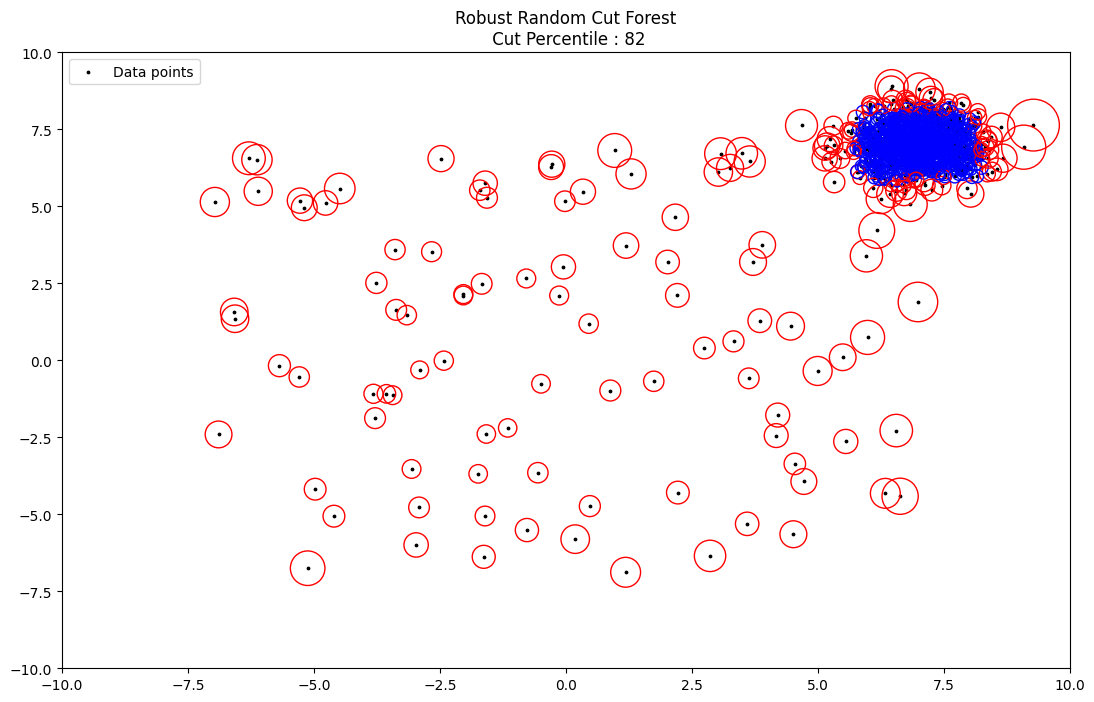

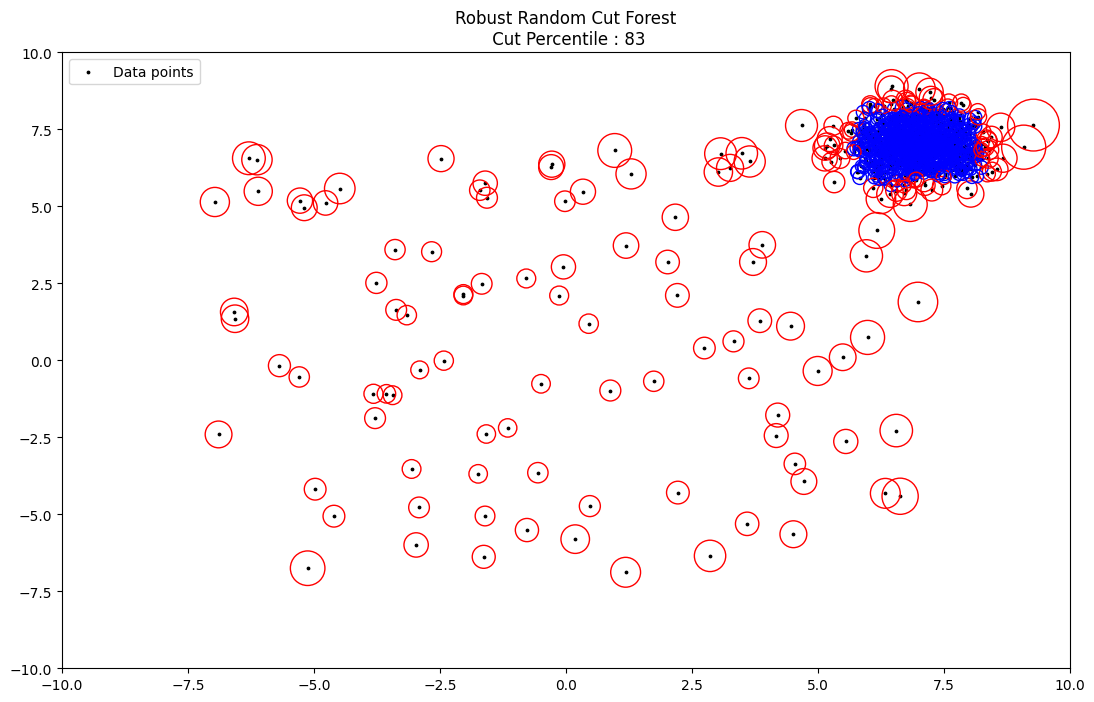

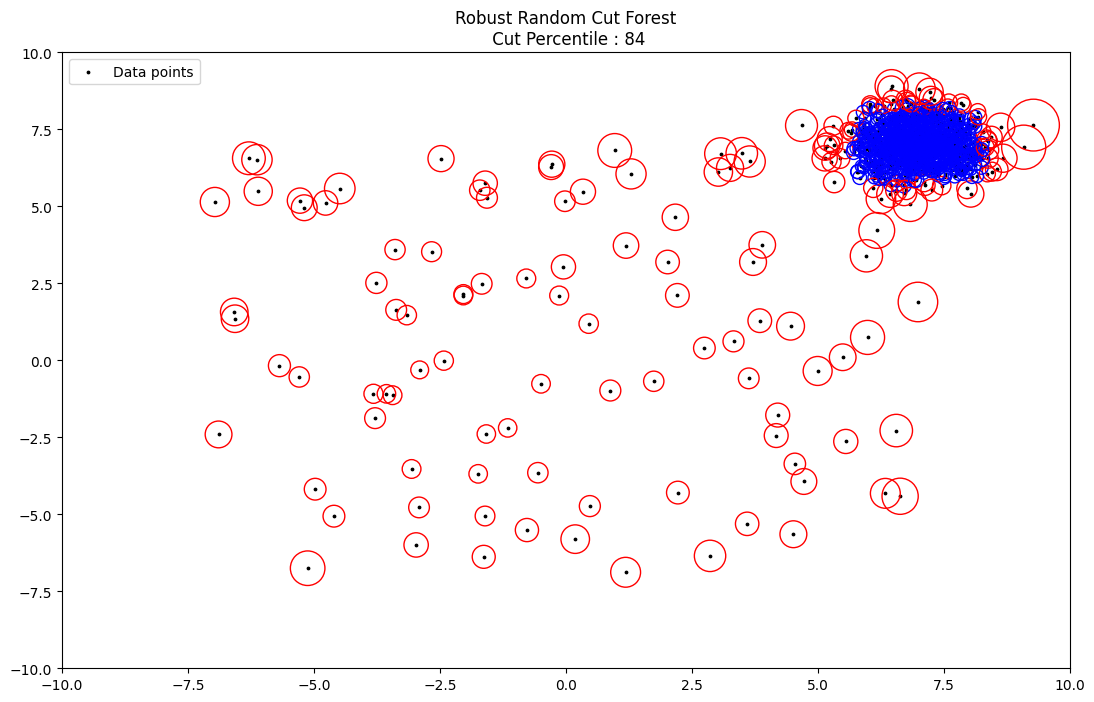

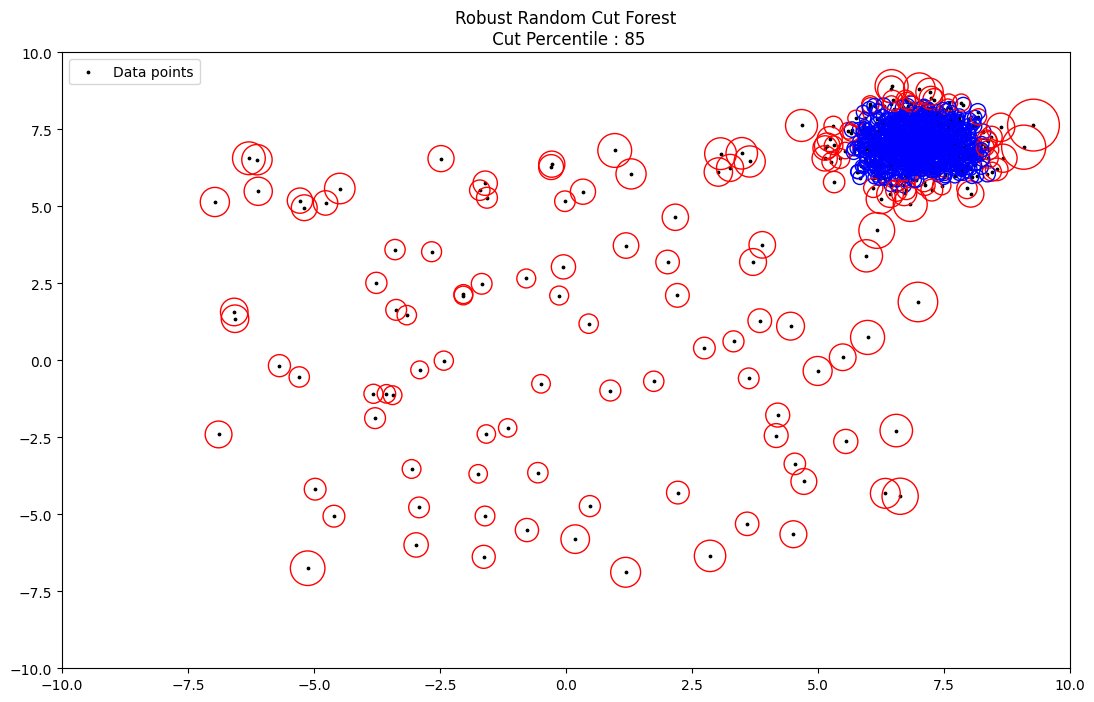

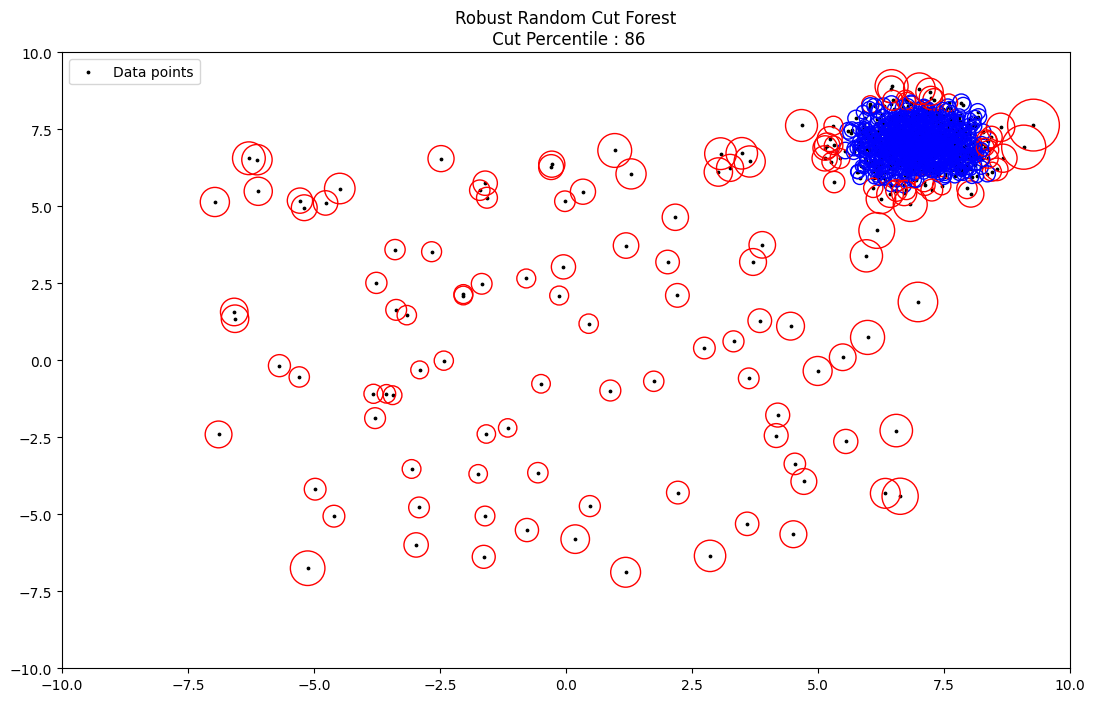

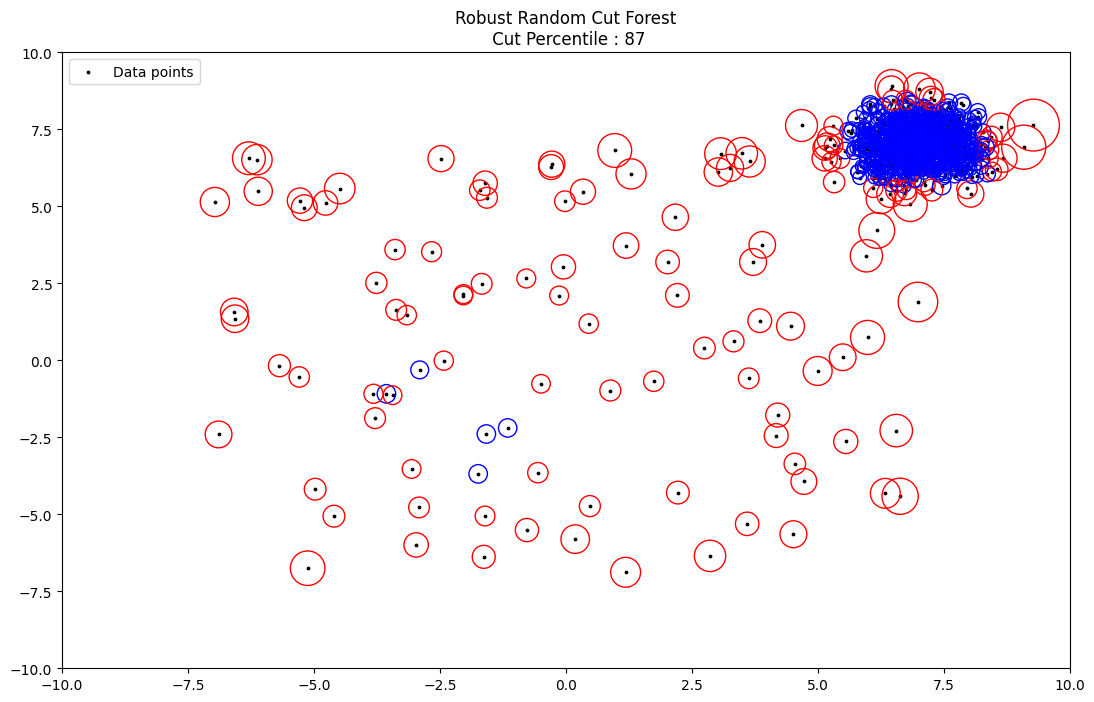

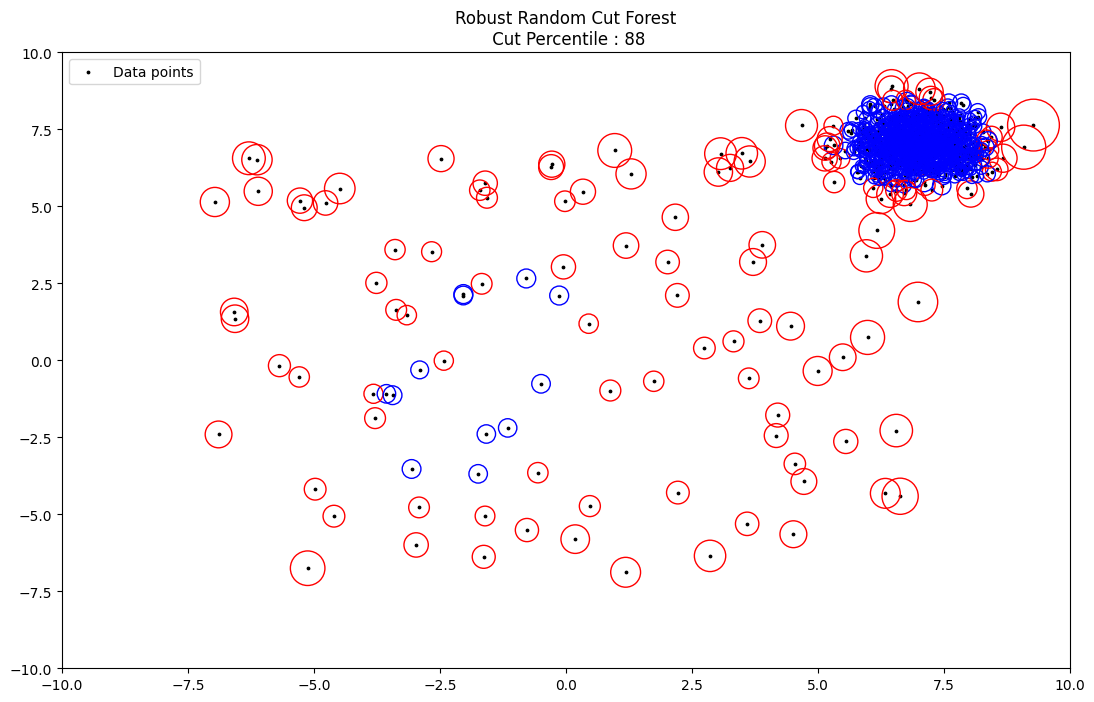

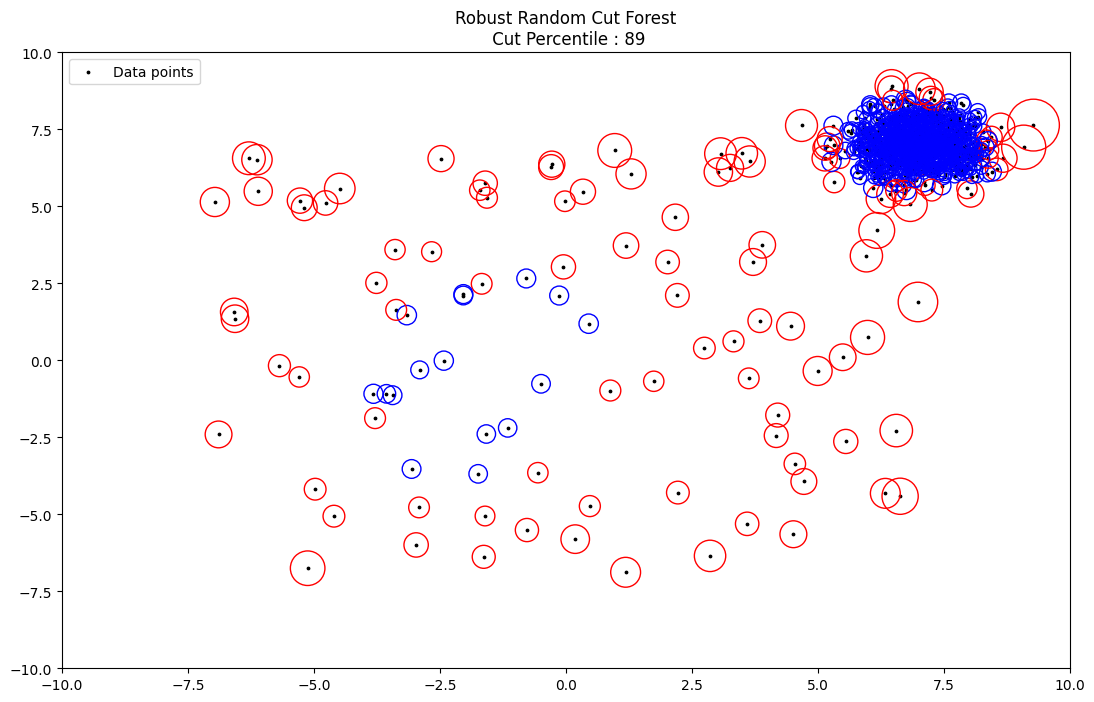

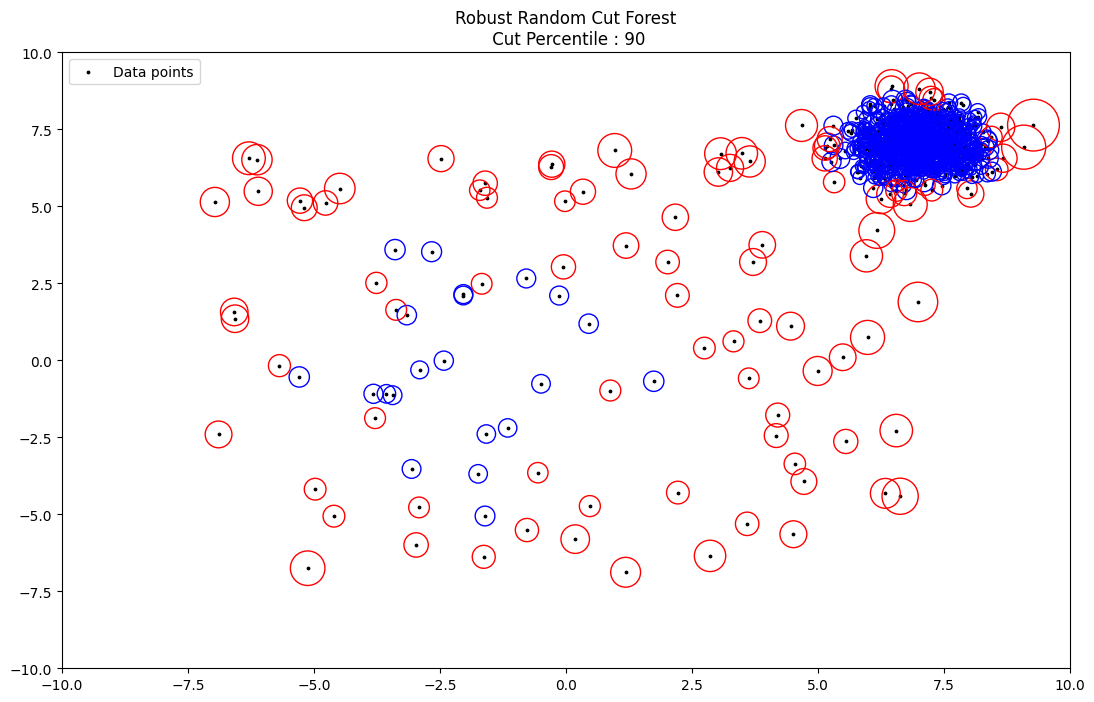

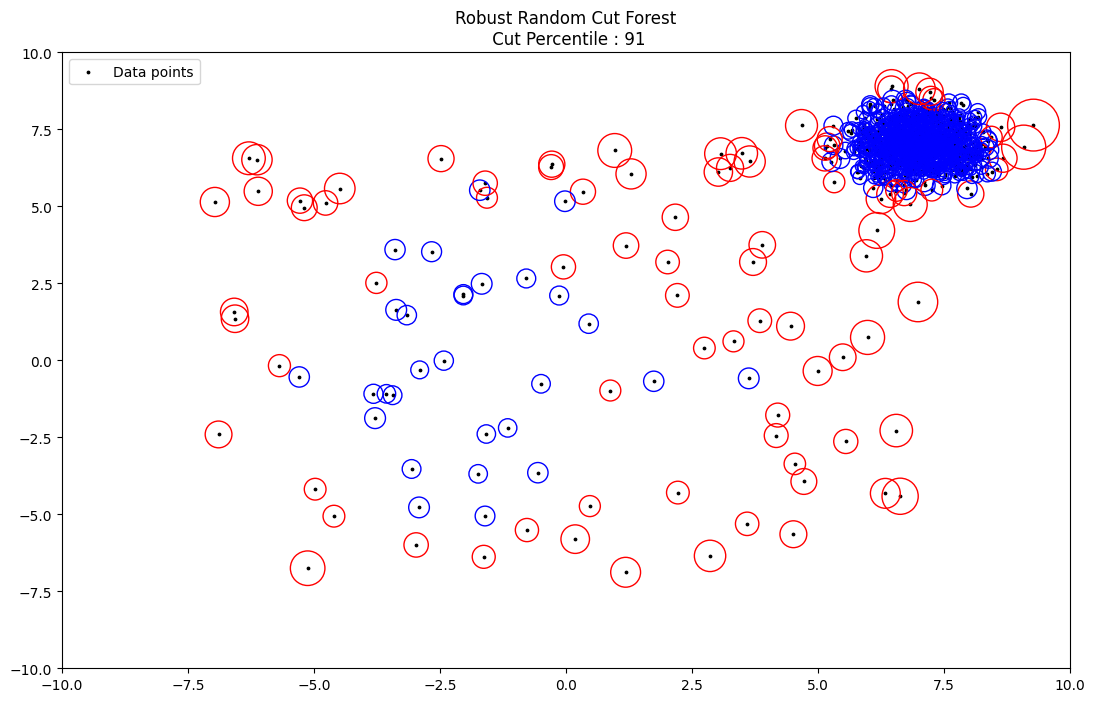

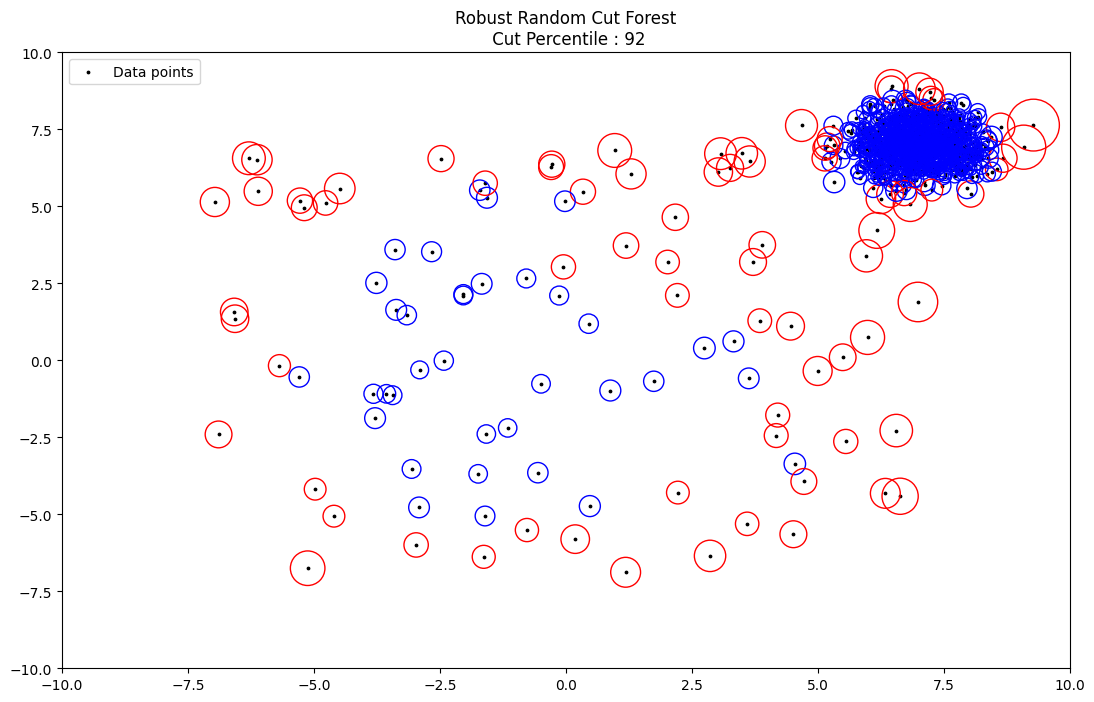

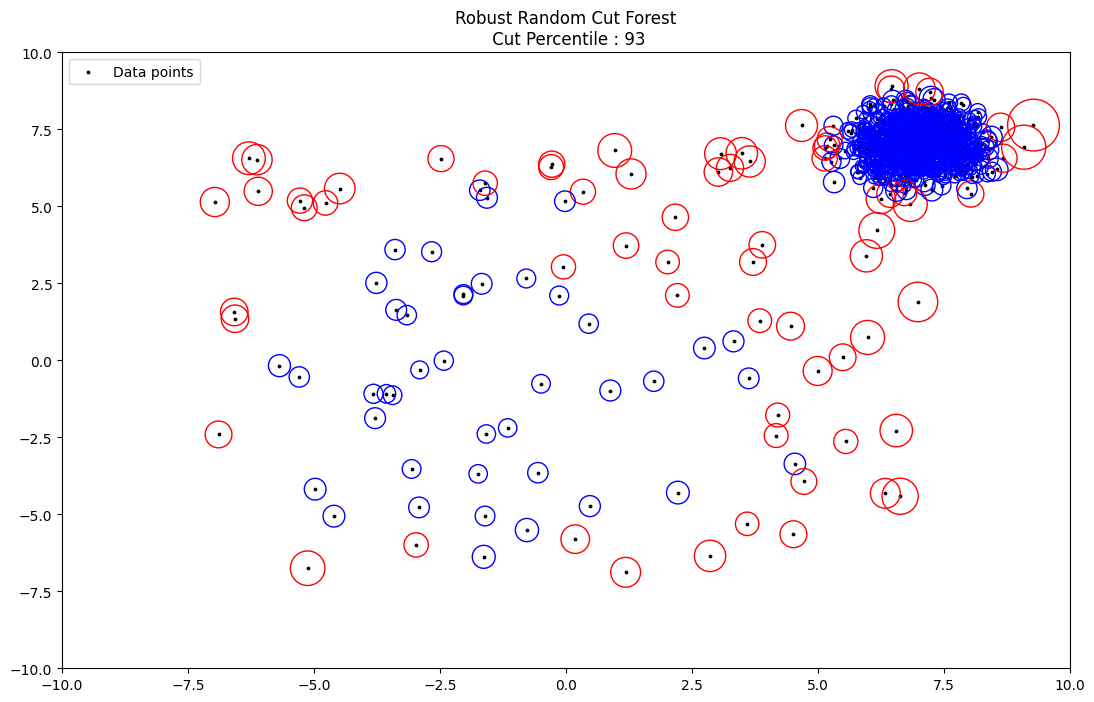

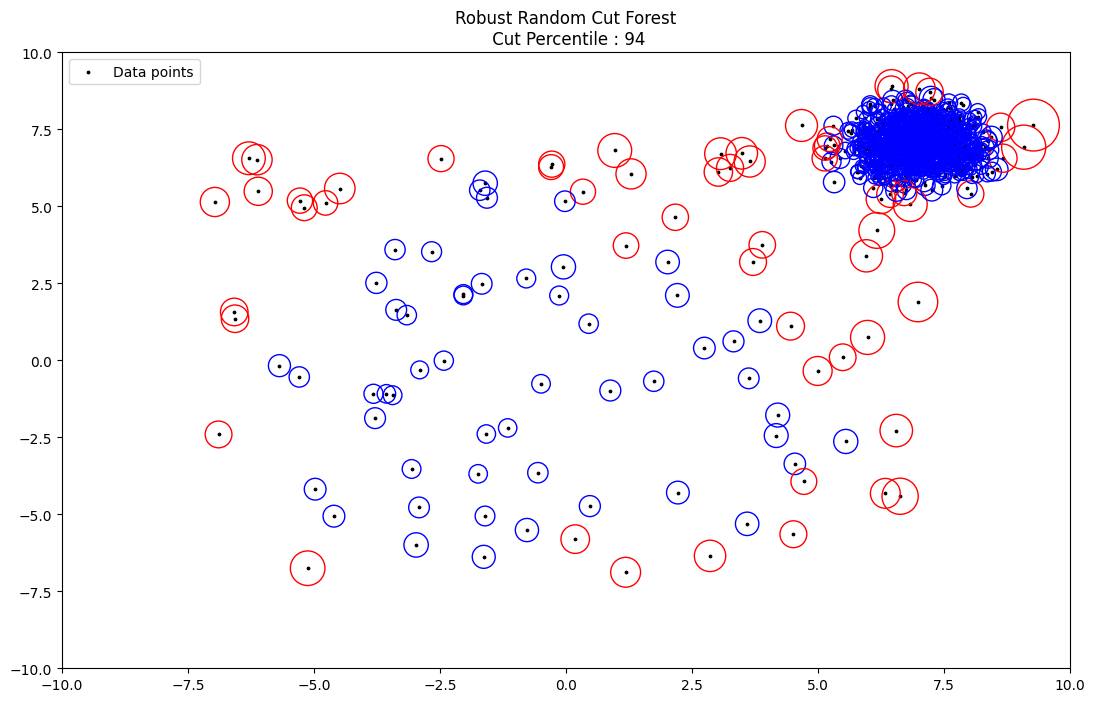

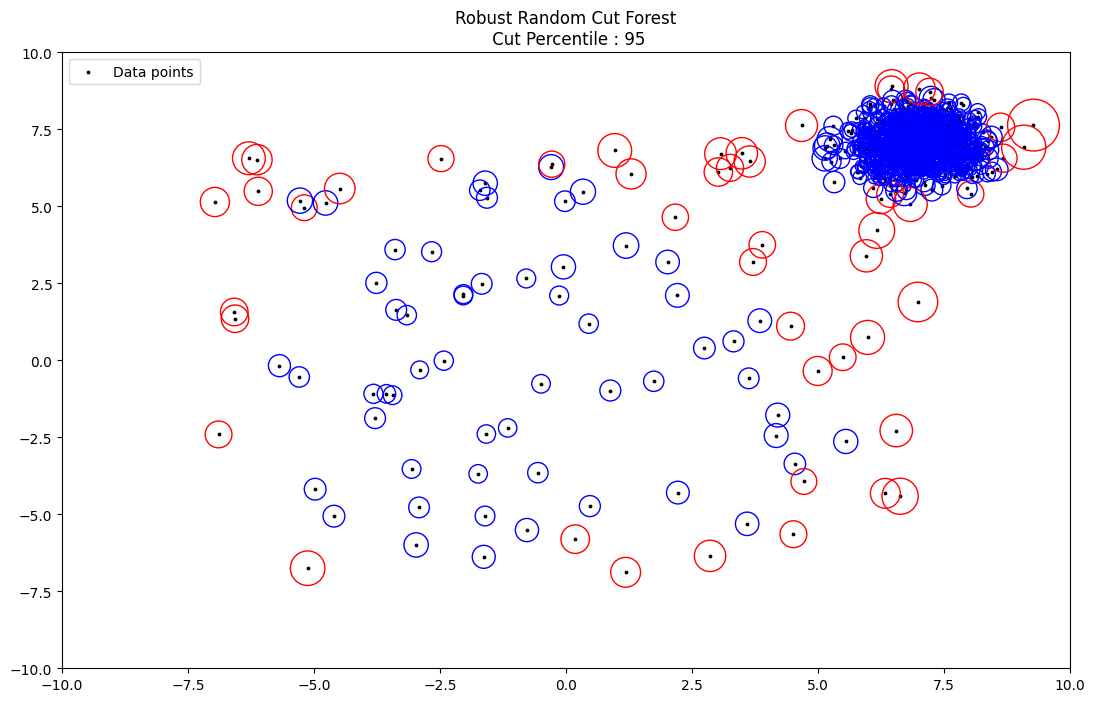

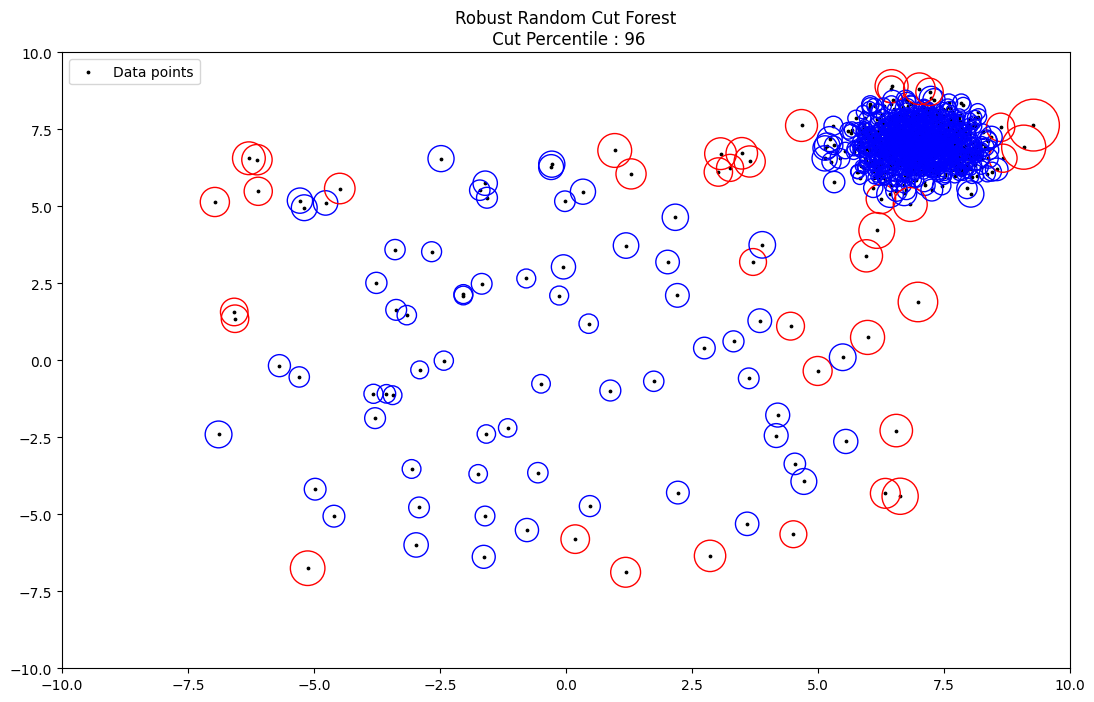

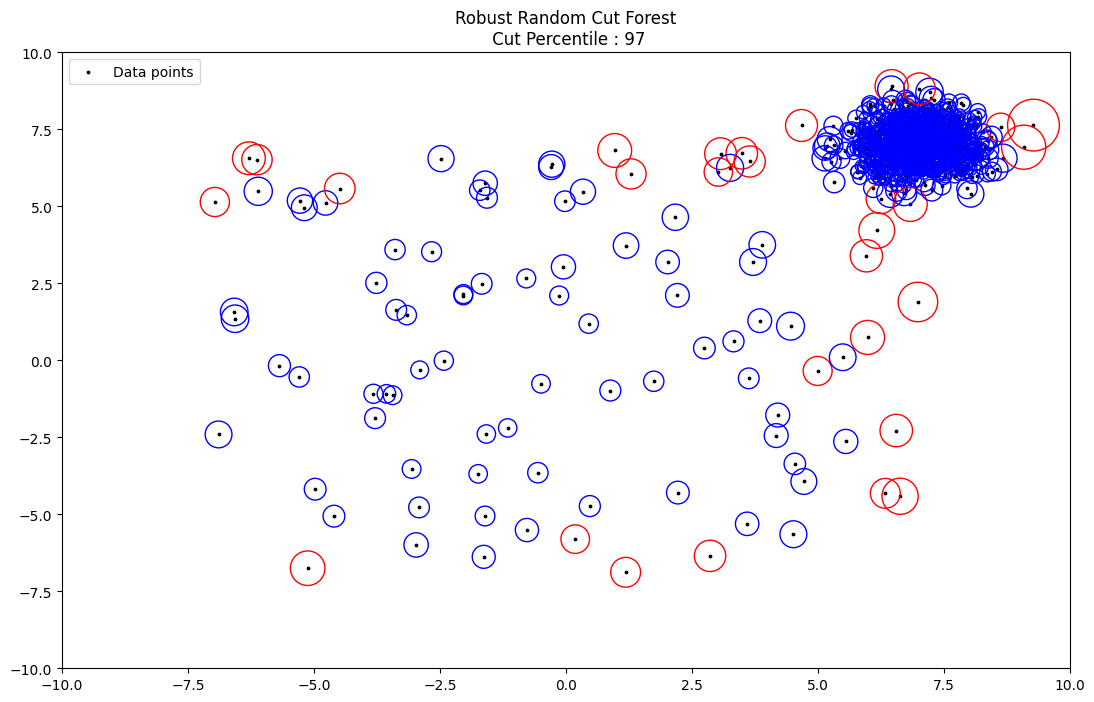

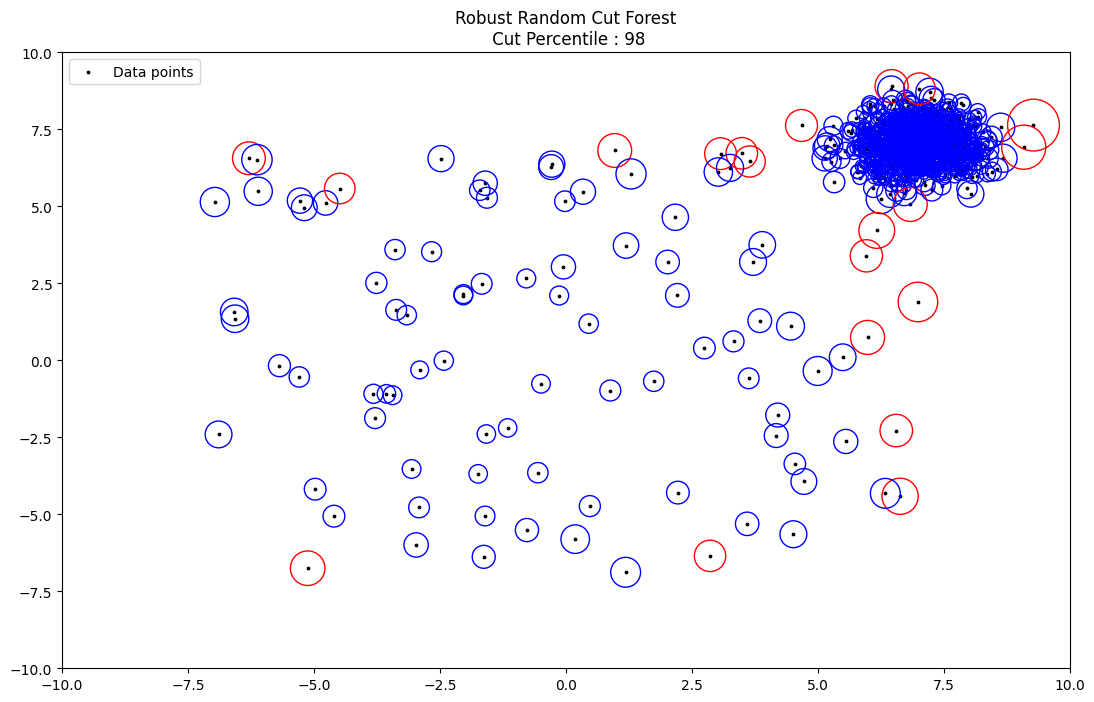

In [9]:
for p in range(80,99):
    plt.figure(figsize=(13,8))
    plt.title("Robust Random Cut Forest\n Cut Percentile : {}".format(p))
    plt.scatter(df.iloc[:, 0], df.iloc[:, 1], color="k", s=3.0, label="Data points")
    # plot circles with radius proportional to the outlier scores
    radius = avg_codisp

    for i in range(df.shape[0]):
        if radius[i] >= np.percentile(radius, p):
                plt.scatter(
                df.iloc[i, 0],
                df.iloc[i, 1],
                s=10 * radius[i],
                edgecolors="r",
                facecolors="none",
                #label="Outlier scores",
            )
        elif radius[i] < np.percentile(radius, p):
                plt.scatter(
                df.iloc[i, 0],
                df.iloc[i, 1],
                s=10 * radius[i],
                edgecolors="b",
                facecolors="none",
                #label="Outlier scores",
            )

    plt.axis("tight")
    plt.xlim((-10, 10))
    plt.ylim((-10, 10))
    #plt.xlabel("prediction errors: %d" % (n_errors))
    legend = plt.legend(loc="upper left")
    #legend.legendHandles[0]._sizes = [10]
    #legend.legendHandles[1]._sizes = [20]
    plt.show()